In [10]:
import matplotlib.pyplot as plt
from helper import *
import os
from wordcloud import WordCloud

## Data Extraction from raw E-Mail Files.

In [11]:
root_dir = os.getcwd()

ham_folder = os.path.join(root_dir,'main_ham')
spam_folder = os.path.join(root_dir,'main_spam')
ham_files = os.listdir(ham_folder)
spam_files = os.listdir(spam_folder)

In [12]:
len(ham_files)

6951

In [13]:
len(spam_files)

2398

In [14]:
test_ham = []
for file in ham_files:
    file_path = os.path.join(ham_folder, file)
    test_ham.append(parse_email(file_path))

test_spam = []
for file in spam_files:
    file_path = os.path.join(spam_folder, file)
    test_spam.append(parse_email(file_path))

In [15]:
print(len(test_ham), len(test_spam))    # All set, parse_email() is able to parse all files.

6951 2398


In [16]:
df = {}
for file in spam_files:
    df[email_to_text(parse_email(os.path.join(spam_folder, file)))] = 'spam'
for file in ham_files:
    df[email_to_text(parse_email(os.path.join(ham_folder, file)))] = 'ham'

In [17]:
data = pd.DataFrame.from_dict(df, orient='index', columns=['label']).reset_index(names='mail')
data.to_csv('datasets/data_v1.csv', index=False)
del df

In [18]:
data[data['mail'] == 'nothing']

,mail,label


In [19]:
data.shape

(6003, 2)

In [20]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


## Cleaning the Dataset and the body text.

In [21]:
data = data.drop(data[data['mail'] == 'nothing'].index, axis=0).reset_index(drop=True)

In [22]:
data.head()

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam
1,Greetings!\n\nYou are receiving this letter be...,spam
2,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
3,"The Need For Safety Is Real In 2002, You Might...",spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [23]:
data.iloc[0,0]

'mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nmv 10 00010.7f5fb525755c45eb78efc18d7c9ea5aa\nmv 100 00100.c60d1c697136b07c947fa180ba3e0441\nmv 101 00101.2dfd7ee79ae439b8d9c38e783a137efa\nmv 102 00102.2e3969075728dde7a328e05d19b35976\nmv 103 00103.8c39bfed2079f865e9dfb75f4416a468\nmv 104 00104.886f4a22362f4d3528c3e675878f17f7\nmv 105 00105.9790e1c57fcbf7885b7cd1719fb4681b\nmv 106 00106.fa6df8609cebb6f0f37aec3f70aa5b9a\nmv 107 00107.f1d4194b57840ea6587b9a73ed88e075\nmv 108 00108.4506c2ef846b80b9a7beb90315b22701\nmv 109 00109.601a9cd8272f22236b27e95dbe2fa22d\nmv 11 00011.2a1247254a535bac29c476b86c708901\nmv 110 00110.20934dc65c9a88fc9c6afda9952ce2c5\nmv 111 00111.a163d41592b3a52747d7521341a961af\nmv 112 00112.ec411d26d1f4decc16af7ef73e69a227\nmv 113 00113.ff113297f0ed07536d288c7b2193a8ec\nmv 114 00114.c104ada3a249e1e1846c0cd156a303e9\nmv 115 00115.d7c257361675ee5d45baa552205fb472\nmv 116 00116.8e13644b995f98dbab198b71e26f67ec\nmv 117 00117.33011fddf61efe5f453a14468ff7e629\nmv 118 00118.4be

In [24]:
data[data['mail'].str.match(r"mv (\d+) (\d{5})\.([a-f0-9]{32})", na=False)]

,mail,label
0,mv 1 00001.bfc8d64d12b325ff385cca8d07b84288\nm...,spam


In [25]:
data = data.drop(index = [0]).reset_index(drop=True)

In [26]:
data.head()

,mail,label
0,Greetings!\n\nYou are receiving this letter be...,spam
1,</TR> Save up to 70% on Life Insurance. Why Sp...,spam
2,"The Need For Safety Is Real In 2002, You Might...",spam
3,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam
4,1) Fight The Risk of Cancer!\nhttp://www.adcli...,spam


In [27]:
data.duplicated().sum()

np.int64(0)

In [28]:
cleaner = CleanBody()

data['mail'] = cleaner.transform(data['mail'])

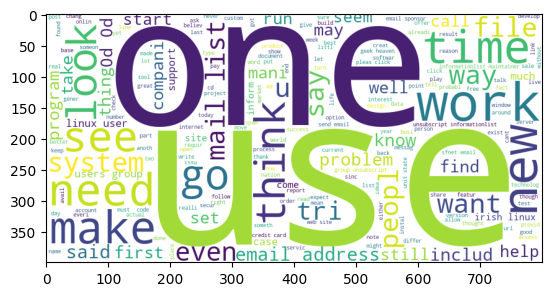

In [29]:
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate(" ".join(data['mail']))
plt.imshow(wc)

# Our class works! We can easily implement a pipeline now.

In [30]:
data[data['mail'] == '']

,mail,label
251,,spam
1596,,spam
3630,,ham


In [31]:
data = data.drop(index = data[data['mail'] == ''].index).reset_index(drop=True)

In [32]:
data.to_csv('datasets/data_v2.csv', index=False)